In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import glob
import shutil
import copy
import random
from tqdm import tqdm
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0


## Training

In [4]:
# moving training/val data
cell_types = ['basophil', 'ig', 'lymphocyte', 'platelet', 'neutrophil', 'eosinophil', 'erythroblast', 'monocyte', 'garbage']
base_dir = '/hddraid5/data/colin/cell_classification/data/PBC_dataset_normal_DIB/'
dst_dir = '/hddraid5/data/colin/cell_classification/data/'
seed = 0
random.seed(seed)
split = 0.85
for cell_type in cell_types:
    all_images = glob.glob(os.path.join(base_dir, cell_type, '*.jpg'))
    random.shuffle(all_images)
    train_amnt = int(len(all_images)*split)
    for i in range(0, train_amnt):
        src = all_images[i]
        dst = os.path.join(dst_dir, 'train', cell_type, os.path.basename(src))
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy2(src, dst)
    for i in range(train_amnt, len(all_images)):
        src = all_images[i]
        dst = os.path.join(dst_dir, 'val', cell_type, os.path.basename(src))
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy2(src, dst)

In [3]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
model_name = 'densenet'
data_dir = '/hddraid5/data/colin/cell_classification/data/'
feature_extract=True
cell_types = ['basophil', 'ig', 'lymphocyte', 'platelet', 'neutrophil', 'eosinophil', 'erythroblast', 'monocyte', 'garbage']
num_classes = len(cell_types)
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [7]:
batch_size=16
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.10, contrast=0.20, saturation=0.20, hue=0.20),
        transforms.RandomAffine(degrees=10, scale=(1.05,0.95), shear=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(params_to_update)

Params to learn:
	 classifier.weight
	 classifier.bias


In [9]:
num_epochs=15
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

  0%|          | 0/1002 [00:00<?, ?it/s]

Epoch 0/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.7910 Acc: 0.7621


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.4804 Acc: 0.8460

Epoch 1/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.4598 Acc: 0.8507


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.3708 Acc: 0.8814

Epoch 2/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3953 Acc: 0.8688


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.3390 Acc: 0.8962

Epoch 3/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3680 Acc: 0.8749


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.3087 Acc: 0.9015

Epoch 4/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3515 Acc: 0.8850


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.3249 Acc: 0.8944

Epoch 5/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3434 Acc: 0.8822


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.3155 Acc: 0.8941

Epoch 6/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3346 Acc: 0.8845


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.3062 Acc: 0.8923

Epoch 7/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3414 Acc: 0.8859


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2803 Acc: 0.9078

Epoch 8/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3292 Acc: 0.8904


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2902 Acc: 0.9011

Epoch 9/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3152 Acc: 0.8924


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2687 Acc: 0.9117

Epoch 10/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3168 Acc: 0.8926


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2772 Acc: 0.9075

Epoch 11/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3141 Acc: 0.8936


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2954 Acc: 0.9025

Epoch 12/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3153 Acc: 0.8933


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2814 Acc: 0.9032

Epoch 13/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3101 Acc: 0.8951


  0%|          | 0/1002 [00:00<?, ?it/s]

val Loss: 0.2816 Acc: 0.9071

Epoch 14/14
----------


  0%|          | 0/177 [00:00<?, ?it/s]

train Loss: 0.3045 Acc: 0.8971


100%|██████████| 177/177 [00:05<00:00, 31.64it/s]


val Loss: 0.2857 Acc: 0.9022

Training complete in 10m 54s
Best val Acc: 0.911723


In [31]:
torch.save(model_ft.state_dict(), 'wbc_dense.pt')

In [4]:
cell_paths = {}
for cell_type in cell_types:
    cell_paths[cell_type] = glob.glob(os.path.join(src_path, cell_type, '*.jpg'))

In [5]:
data_shape = (224, 224)

In [22]:
jitter = torchvision.transforms.ColorJitter(brightness=0.20, contrast=0.20, saturation=0.20, hue=0.20)

In [35]:
feature_extract = True

In [14]:
pim = Image.fromarray(image)

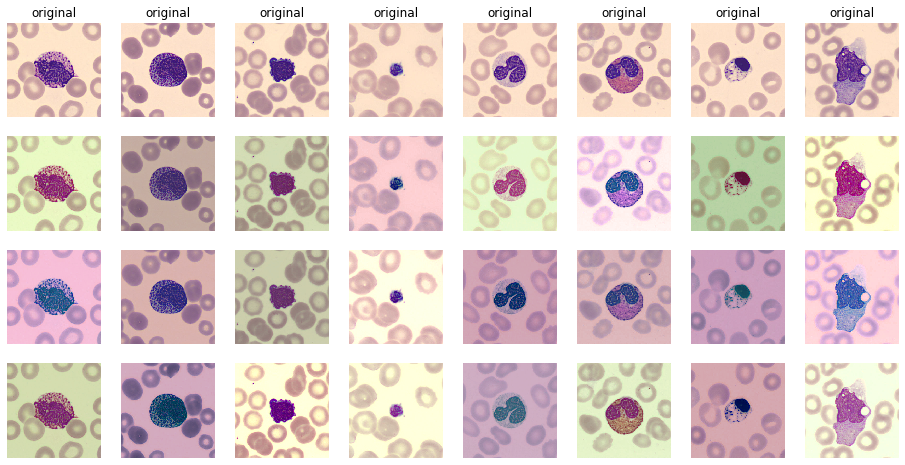

In [34]:
fig, axss = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(8):
    image = io.imread(cell_paths[cell_types[i]][0])
    pim = Image.fromarray(image)
    axss[0,i].imshow(pim)
    axss[0,i].axis('off')
    axss[0,i].set_title("original")
    for j in range(3):
        jittered = jitter(pim)
        axss[j+1,i].imshow(jittered)
        axss[j+1, i].axis('off')

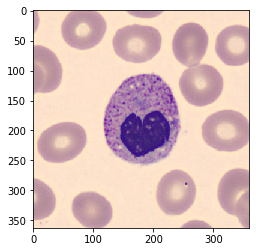

In [28]:
plt.imshow(pim)

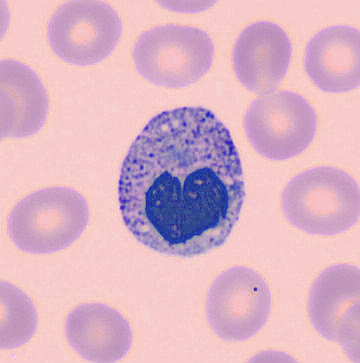

In [27]:
jittered = jitter(pim)

IndexError: list index out of range

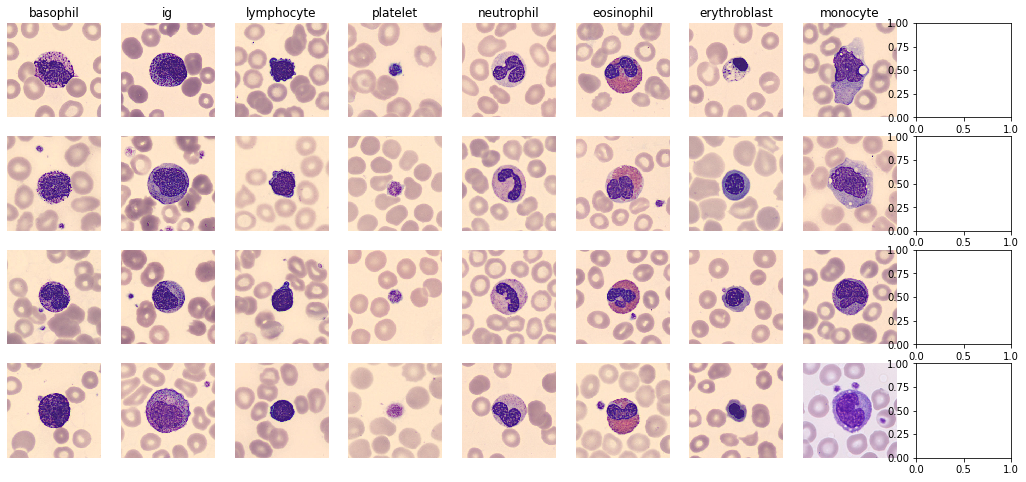

In [6]:
fig, axss = plt.subplots(nrows=4, ncols=9, figsize=(18,8))
for i, cell_type in enumerate(cell_types):
    for j in range(4):
        image = io.imread(cell_paths[cell_type][j])
        axs = axss[j,i]
        axs.imshow(image)
        axs.axis('off')
    axss[0,i].set_title(cell_type)

In [9]:
# hacky load
cell_images = []
cell_labels = []
for cell_type in tqdm(cell_types):
    for cell_path in cell_paths[cell_type]:
        cell_labels.append(cell_type)
        image = io.imread(cell_path)
        image = transform.resize(image, data_shape)
        cell_images.append(image)

<ipython-input-9-9362b6286e7e>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for cell_type in tqdm(cell_types):


KeyboardInterrupt: 

In [9]:
label_indices = {
    label: index for index, label in enumerate(cell_types)
}

In [10]:
# lets generate our training data
x_data = np.array(cell_images) / 255
y_data = keras.utils.to_categorical(np.array([label_indices[cell_label] for cell_label in cell_labels]))

In [11]:
x_data = (x_data - np.mean(x_data.reshape(-1, 3), axis=0))/np.std(x_data.reshape(-1, 3), axis=0)

In [12]:
split = 0.8
seed = 0
indices = np.arange(0, len(y_data))
np.random.seed(seed)
np.random.shuffle(indices)
train_amount = int(len(indices)*split)
train_indices = indices[:train_amount]
val_indices = indices[train_amount:]

In [13]:
train_x = x_data[train_indices]
train_y = y_data[train_indices]
val_x = x_data[val_indices]
val_y = y_data[val_indices]

In [14]:
def get_model(input_shape=(224,224,3), model_name='mobilenet_v2'):
    if model_name == 'mobilenet_v2':
        base_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    else:
        base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    inputs = keras.Input(shape=input_shape)
    base_model.trainable = False
    x = base_model(inputs, training=False) # IMPORTANT
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x) # just train this and following layer
    outputs = keras.layers.Dense(9, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [15]:
image_proc = keras.preprocessing.image.ImageDataGenerator(rotation_range=45, horizontal_flip=True, vertical_flip=True, shear_range=5, zca_whitening=True)

/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [20]:
val_x[::100].shape

(35, 224, 224, 3)

In [16]:
val_x.dtype

dtype('float64')

In [ ]:
image_proc.fit(val_x[0:1], )

In [21]:
transformed = image_proc.flow(val_x)

In [23]:
for item in transformed:
    break

/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [24]:
item

array([[[[ 0.93855226,  0.74441797,  0.7238881 ],
         [ 0.93855226,  0.74441797,  0.7238881 ],
         [ 0.93855226,  0.74441797,  0.7238881 ],
         ...,
         [ 0.9449973 ,  0.78672373,  0.7378789 ],
         [ 0.93214774,  0.75085866,  0.70668316],
         [ 0.9726657 ,  0.77105033,  0.7163256 ]],

        [[ 0.93855226,  0.74441797,  0.7238881 ],
         [ 0.93855226,  0.74441797,  0.7238881 ],
         [ 0.93855226,  0.74441797,  0.7238881 ],
         ...,
         [ 0.95334774,  0.78672373,  0.73998094],
         [ 0.9237973 ,  0.7454663 ,  0.70037717],
         [ 0.98519135,  0.77824014,  0.7226316 ]],

        [[ 0.93855226,  0.74441797,  0.7238881 ],
         [ 0.93855226,  0.74441797,  0.7238881 ],
         [ 0.93855226,  0.74441797,  0.7238881 ],
         ...,
         [ 0.9616982 ,  0.78672373,  0.7420829 ],
         [ 0.9154469 ,  0.7400739 ,  0.6940712 ],
         [ 0.99771696,  0.78542995,  0.72893757]],

        ...,

        [[-0.38809133, -0.12285033, -0

In [34]:
model = get_model(model_name='dense')
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
callbacks = keras.callbacks.ModelCheckpoint('densenet_cellclass.hdf5')
model.fit(image_proc.flow(train_x, train_y, batch_size=16),
                    steps_per_epoch=len(train_x) / 16, epochs=20, validation_data=(val_x, val_y), shuffle=False, callbacks=[callbacks])

29089792/29084464 [==============================] - 3s 0us/step
  ...
    to  
  ['...']
Train for 942.5 steps, validate on 3770 samples
Epoch 1/20
943/942 [==============================] - 180s 191ms/step - loss: 0.6643 - accuracy: 0.7835 - val_loss: 0.5420 - val_accuracy: 0.8263
Epoch 2/20
943/942 [==============================] - 182s 193ms/step - loss: 0.3425 - accuracy: 0.8828 - val_loss: 0.3427 - val_accuracy: 0.8947
Epoch 3/20
943/942 [==============================] - 182s 193ms/step - loss: 0.3000 - accuracy: 0.8985 - val_loss: 0.2999 - val_accuracy: 0.9048
Epoch 4/20
943/942 [==============================] - 181s 192ms/step - loss: 0.2803 - accuracy: 0.9055 - val_loss: 0.3391 - val_accuracy: 0.8889
Epoch 5/20
943/942 [==============================] - 174s 185ms/step - loss: 0.2548 - accuracy: 0.9117 - val_loss: 0.2548 - val_accuracy: 0.9162
Epoch 6/20
943/942 [==============================] - 169s 179ms/step - loss: 0.2443 - accuracy: 0.9158 - val_loss: 0.2442 - val_acc

In [35]:
model.fit(image_proc.flow(train_x, train_y, batch_size=16),
                    steps_per_epoch=len(train_x) / 16, epochs=6, validation_data=(val_x, val_y), shuffle=False, callbacks=[callbacks])

  ...
    to  
  ['...']
Train for 942.5 steps, validate on 3770 samples
Epoch 1/6
943/942 [==============================] - 175s 186ms/step - loss: 0.1739 - accuracy: 0.9406 - val_loss: 0.2089 - val_accuracy: 0.9284
Epoch 2/6
943/942 [==============================] - 167s 178ms/step - loss: 0.1645 - accuracy: 0.9419 - val_loss: 0.2700 - val_accuracy: 0.9058
Epoch 3/6
943/942 [==============================] - 171s 181ms/step - loss: 0.1593 - accuracy: 0.9454 - val_loss: 0.2053 - val_accuracy: 0.9353
Epoch 4/6
943/942 [==============================] - 177s 188ms/step - loss: 0.1588 - accuracy: 0.9444 - val_loss: 0.2417 - val_accuracy: 0.9225
Epoch 5/6
943/942 [==============================] - 166s 176ms/step - loss: 0.1599 - accuracy: 0.9429 - val_loss: 0.2534 - val_accuracy: 0.9162
Epoch 6/6
943/942 [==============================] - 170s 180ms/step - loss: 0.1544 - accuracy: 0.9474 - val_loss: 0.2273 - val_accuracy: 0.9284


In [ ]:
# need to setup a confusion matrix to understand if the classification of the new class is OK/what it is most similar to

# we may need to add additional augmentation to take into account inter-system variarance which would prevent the classifier from being useful on other systems

In [36]:
saved_model = keras.models.load_model('densenet_cellclass.hdf5')

In [37]:
predicted = saved_model.predict(val_x)

In [42]:
pred_max = np.argmax(predicted, axis=-1)
act_max = np.argmax(val_y, axis=-1)

In [50]:
len(cell_types)

9

In [51]:
confusion = metrics.confusion_matrix(act_max, pred_max)

([<matplotlib.axis.YTick at 0x7fe9ec4c9a90>,
 [Text(0, 0, 'basophil'),
  Text(0, 0, 'ig'),
  Text(0, 0, 'lymphocyte'),
  Text(0, 0, 'platelet'),
  Text(0, 0, 'neutrophil'),
  Text(0, 0, 'eosinophil'),
  Text(0, 0, 'erythroblast'),
  Text(0, 0, 'monocyte'),
  Text(0, 0, 'garbage')])

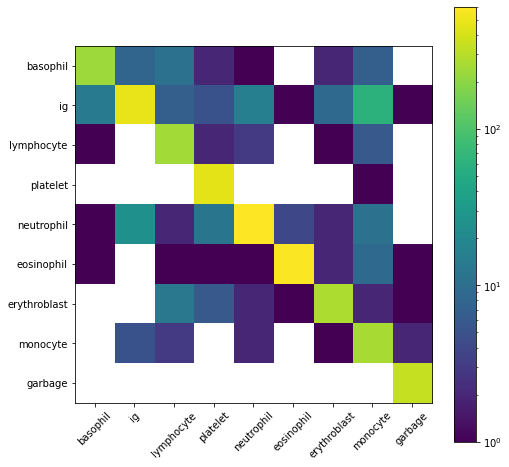

In [65]:
plt.figure(figsize=(8,8))
from matplotlib.colors import LogNorm
plt.imshow(confusion, norm=LogNorm())
plt.colorbar()
plt.xticks(np.arange(0, 9), cell_types, rotation=45)
plt.yticks(np.arange(0, 9), cell_types)

In [ ]:
plt.